# Eindopdracht begin begin

In [1]:
import torch
from torch import nn, Tensor
import torch.nn.functional 
from torchvision.transforms import functional as F

from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset, Subset
from pipetorch.data import read_from_kaggle, plot_boundaries
from pipetorch.train import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import os
from pathlib import Path  # Import Path from pathlib
from PIL import Image, ImageEnhance, ImageDraw
from sklearn.metrics import r2_score
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import re

from optuna.visualization.matplotlib import plot_slice, plot_contour
from optuna import create_study, TrialPruned
import cv2
import random

#### kijken of de folder bestaat en inlaad

In [2]:
folder = '/datb/BotsNLE/angle90'
!ls $folder | head

0000-0.02--0.5625.jpg
0001-0.33--1.6875.jpg
0002-0.62--1.125.jpg
0003-0.91--4.21875.jpg
0004-1.21-3.375.jpg
0005-1.50--3.9374999999999996.jpg
0006-1.81--4.21875.jpg
0007-2.13--1.125.jpg
0008-2.43-2.25.jpg
0009-2.73--3.0937500000000004.jpg
ls: write error: Broken pipe


#### Inladen van data en ruis toevoegen

In [45]:
class AugmentationTransform:
    def __call__(self, image):
        return Augmentation(image)  # This will now always return a single image
    
def adjust_brightness(image):
    # Convert the image to a numpy array
    image_array = np.array(image).astype(np.float32)  # Ensure it's in float32 for multiplication

    # Apply random brightness adjustment factor
    alpha = np.random.uniform(0.15, 1.7)
    adjusted = np.clip(alpha * image_array, 0, 255)  # Clip to valid pixel range (0-255)
    adjusted = adjusted.astype(np.uint8)  # Convert back to uint8 type for image

    # Convert back to a PIL image
    adjusted_image = Image.fromarray(adjusted)
    return adjusted_image

def add_random_lines(image):
    # Copy the image to avoid modifying the original one
    image_with_lines = image.copy()
    
    # Get the dimensions of the image
    width, height = image_with_lines.size  # Use .size instead of .shape
    num_lines = np.random.randint(1, 6)

    for _ in range(num_lines):
        # Generate random points for the line
        x1, y1 = np.random.randint(0, width), np.random.randint(0, height)
        x2, y2 = np.random.randint(0, width), np.random.randint(0, height)

        # Draw the line
        draw = ImageDraw.Draw(image_with_lines)
        draw.line([x1, y1, x2, y2], fill=0, width=np.random.randint(1,14))

    return image_with_lines


def Augmentation(image):
    chance = np.random.uniform()
    if chance < 0.5:
        if chance < 0.18:
            image = adjust_brightness(image)
        elif chance <= 0.32:
            image = adjust_brightness(image)
            image = add_random_lines(image)
        else:
            image = add_random_lines(image)
    return image  # Always return a single image, not a list


# Extract labels from file names
def extract_labels(input_path):
    filename = Path(input_path).stem
    parts = re.split(r'-(?![^-]-)', filename, maxsplit=2)
    if len(parts) >= 3 and parts[-1]:
        y = float(parts[-1])
        y = y / 90  # Normalize between -1 and 1
        return y
    else:
        print(f"Skipping file (not enough parts to extract labels): {filename}")

In [46]:
# voor het inladen van de afbeedingen in het juiste format
class FileDataset(Dataset):
    def __init__(self, folder, image_size, extension='jpg'):
        super().__init__()
        self.files = list(Path(folder).expanduser().glob(f'*.{extension}'))

        # Transformations to apply to the images
        self.transform_normal_data = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])
        
        self.transform_new_data = transforms.Compose([
            AugmentationTransform(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

        # Lijsten voor afbeeldingen en labels
        self.file = []
        self.file_new  = []
        
        # Laad afbeeldingen en labels
        self._load_images_and_labels()
        
        # files samenvoegen
        print(len(self.file))
        print(len(self.file_new))
        self.file = self.file + self.file_new
        random.shuffle(self.file)
        
    def _load_images_and_labels(self):
        for img_path in self.files:
            # Laad de afbeelding
            img_og = Image.open(img_path)  
            flipped_img_og = F.hflip(img_og)  # Flip image horizontally

            # Extract the corresponding label for the image using the filename
            y = extract_labels(img_path)
            label = torch.tensor(y, dtype=torch.float32).view(1)  # Ensure label shape is [1]

            if label is None:
                raise ValueError(f"No label found for image: {img_path.name}")
            
            # Apply the transformation (resize, to tensor)
            img = self.transform_normal_data(img_og)
            flipped_img = self.transform_normal_data(flipped_img_og)
            
            img_new = self.transform_new_data(img_og)
            flipped_img_new = self.transform_new_data(flipped_img_og)
   
            # Voeg de originele afbeelding toe met label in een tupil
            self.file.append((img, label))
            self.file.append((flipped_img, -label))

            # voeg de nieuwe afbeelding toe
            if len(img_new) != 0:
                self.file_new.append((img_new,label))
                
            if len(flipped_img_new) != 0:
                self.file_new.append((flipped_img_new, -label))
           
    def __len__(self):
        return len(self.file)

    def __getitem__(self, i):       
        file = self.file[i]
        return file


In [47]:
image_size = 32
batch_size = 32
folder = '/datb/BotsNLE/angle90'
ds = FileDataset(folder, image_size, extension='jpg')
len(ds)

1624
1624


3248

In [48]:
dataset_size = len(ds)
train_size = int(0.80 * dataset_size)
valid_size = dataset_size - train_size


train_ds, valid_ds = random_split(ds, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=batch_size,
                            shuffle=True, num_workers=2)

valid_dl = DataLoader(valid_ds, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [49]:
ds1 = train_dl.dataset
X, y = ds1[0]
X.shape, y.shape, y, ds1[0]



(torch.Size([3, 32, 32]),
 torch.Size([1]),
 tensor([-0.0406]),
 (tensor([[[0.3647, 0.3843, 0.4118,  ..., 0.0824, 0.0863, 0.0941],
           [0.3922, 0.4000, 0.4392,  ..., 0.0784, 0.0863, 0.1412],
           [0.4039, 0.4157, 0.4667,  ..., 0.0510, 0.0627, 0.1608],
           ...,
           [0.7020, 0.7255, 0.7490,  ..., 0.7490, 0.7255, 0.7020],
           [0.6784, 0.7176, 0.7451,  ..., 0.7412, 0.7098, 0.6902],
           [0.6549, 0.6980, 0.7333,  ..., 0.7294, 0.6980, 0.6706]],
  
          [[0.4824, 0.4824, 0.4980,  ..., 0.1098, 0.1176, 0.1412],
           [0.4902, 0.4941, 0.5255,  ..., 0.1020, 0.1176, 0.1725],
           [0.4980, 0.5020, 0.5451,  ..., 0.0667, 0.1020, 0.2314],
           ...,
           [0.7765, 0.7922, 0.8039,  ..., 0.7922, 0.7765, 0.7569],
           [0.7647, 0.7922, 0.8039,  ..., 0.7843, 0.7686, 0.7490],
           [0.7647, 0.7843, 0.8039,  ..., 0.7843, 0.7608, 0.7412]],
  
          [[0.3765, 0.3686, 0.3961,  ..., 0.0980, 0.1020, 0.1294],
           [0.4000, 0.400

In [50]:
def showx(x):
    plt.imshow(np.transpose(x,(1,2,0)))
    
def demo_batch():
    real_batch = next(iter(train_dl))
    images, labels = real_batch
    remove_upper_half = transforms.Lambda(lambda images: images[:, :, 19:, :])  # Removes upper half, hogere waarden voor x in [:,:,x:,:] betekend een grter deel wat van boven gekropt wordt bij 19 is er nog wel wat ruis in het model maar duidelijk alleen de lijn in beeld
    images = remove_upper_half(images)

    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.title("Training Images")
    showx(vutils.make_grid(images[:24], padding=2, normalize=True))

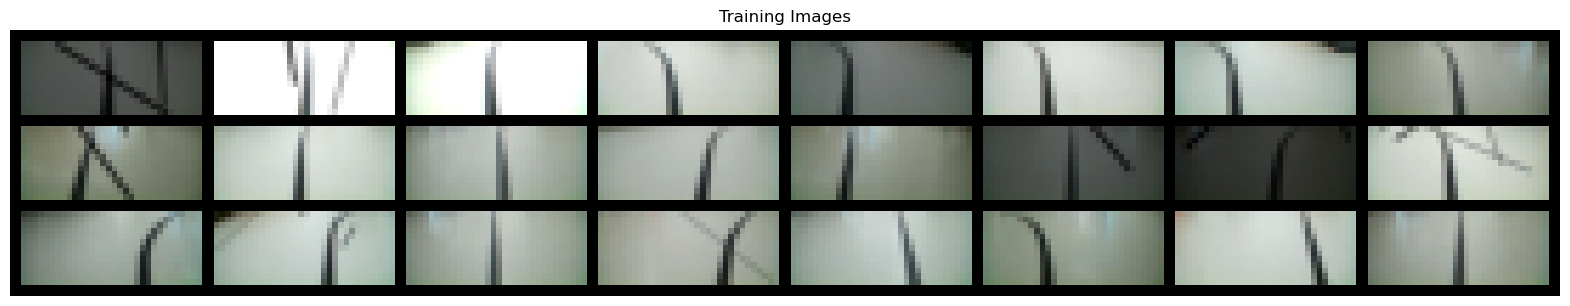

In [51]:
demo_batch()

## Model en augmentatie maken

In [52]:
class RemoveUpperHalf(nn.Module):
    def forward(self, img):
        # Remove the upper half of the image (assuming channel-first format)
        height = img.shape[2]
        im = img[:, :, height//2 + 4 :, :]
        return im

def hoeken(img):
    # Hoeken bijwerken
    for k in img:
        for j in range(len(k)-1):
            if np.all(k[j] == 0):  # Use np.all to check if all elements in k[j] are 0
                break
            k[j] = 0
    for k in img:
        for j in range(len(k)-1, 0, -1):
            if np.all(k[j] == 0):  # Use np.all to check if all elements in k[j] are 0
                break
            k[j] = 0

    # Zorg ervoor dat de afbeelding geen extra dimensie heeft
    if len(img.shape) == 5:  # [1, 1, 1, 32, 32] -> heeft een extra dimensie
        img = img.squeeze()  # Verwijder de eerste dimensie (batch size 1)

    # Als het nog steeds 4D is (batch_size, channels, height, width), dan is het goed
    images_edited = img
    return images_edited


class ThresholdBinary(nn.Module):
    def forward(self, img):
        # Controleer dat de input een batch tensor is
        if len(img.shape) != 4:
            raise ValueError(f"Expected 4D input (batch, channel, height, width), but got {img.shape}")
        
        # Squeeze om numpy-conversie mogelijk te maken (zonder de batch/kanaal-informatie te verliezen)
        img_np = img.squeeze(1).cpu().numpy()  # Verwijder de channel-dimensie (batch blijft)

        # Gebruik OpenCV om een drempelwaarde toe te passen     
        _, thresh = cv2.threshold(img_np, -1, 1, cv2.THRESH_BINARY_INV)
       # print(thresh)
       # print(len(thresh))
        #img_hoek = hoeken(thresh)
        
        # Zet terug naar PyTorch tensor
        img_thresh = np.stack(thresh)  # Combineer de batch-afbeeldingen
        img_tensor = torch.tensor(img_thresh, dtype=torch.float32).unsqueeze(1).to(img.device)  # Voeg channel-dimensie terug
        
        
        return img_tensor

def convolutional_layer_image():
    return   nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

def conv_layer():
    return nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Flatten(1),
            nn.Linear(32 * 33 * 33, 1)
        )

class Standaardiseren(nn.Module):
    def forward(self, images_edited):
        # standaardiseren
        images_edited = (images_edited - torch.mean(images_edited)) / torch.std(images_edited)
        return images_edited
    


In [53]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
      #  self.normalize = transforms.Normalize(mean, std)
    

        self.augment = nn.Sequential(
             transforms.Grayscale(num_output_channels=1),
             RemoveUpperHalf(),
             transforms.Resize((32, 32), antialias=True),
             Standaardiseren(),
             ThresholdBinary(),)
        
        self.conv = conv_layer()
        
        self.convolution_image = convolutional_layer_image()

    def forward(self, X):
        X = X.float()
        X = self.augment(X)

        if len(X.shape) != 4:
            raise ValueError(f"Input must have 4 dimensions, but got {X.shape}")
            
        X = self.conv[:-2](X)
       #print("Shape after convolution:", X.shape)
        X = self.conv[-2:](X)
        return X

In [57]:
def augmentation_visualisation_with_conv(Model):
    """
    Visualizes the original, augmented, and convolutional results of an image.
    
    Parameters:
        model: The model containing the augmentation and convolution logic.
        sample_image: A single input image tensor.
    """

    # Instantiate and evaluate the model
    model = Model
    model.eval()  # Ensure the model is in evaluation mode

    # Load a single example from your dataset
    sample_image, _ = next(iter(train_dl))  # Assuming train_dl is your DataLoader
    sample_image = sample_image[:1]  # Take a single image (batch size = 1)

    # Normalize and augment the input
  #  normalized_image = model.normalize(sample_image)
   # print(f'normalized image shape{normalized_image.shape}')
   
    
    augmented_image = model.augment(sample_image)
    print(f'Augmented image shape{augmented_image.shape}')

    # Extract convolutional features
    conv_output = model.convolution_image(augmented_image)
    print(f'conv_output shape{conv_output.shape}')

    # Augmented image
    augmented_image_squeezed = augmented_image[0].squeeze().detach().cpu().numpy()

    # Convolutional output (take the first channel)
    conv_output_channel = conv_output[0, 0].detach().cpu().numpy()


    # Plot all three images side by side
    fig, axes = plt.subplots(1, 2)
    
    axes[1].imshow(augmented_image_squeezed, cmap="gray")
    axes[1].set_title("Augmented Image")
    axes[1].axis("off")

    # Convolutional output
    axes[0].imshow(conv_output_channel, cmap="gray")
    axes[0].set_title("Convolutional Output")
    axes[0].axis("off")

    # Display the plot
    plt.tight_layout()
    plt.show()

In [58]:
model = Model()

Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 33, 33])


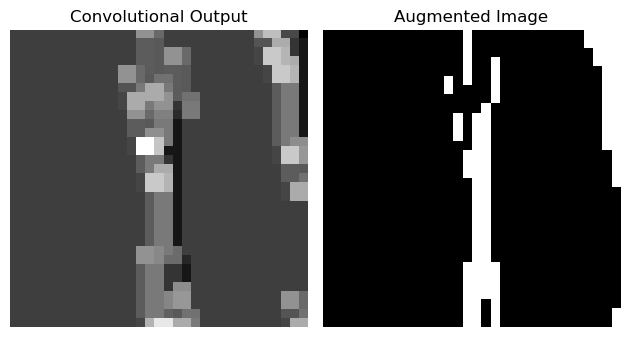

Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 33, 33])


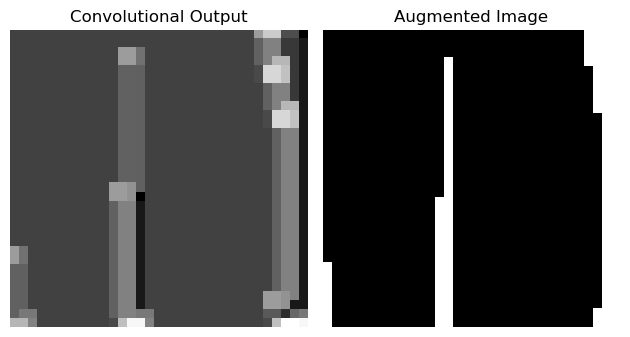

Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 33, 33])


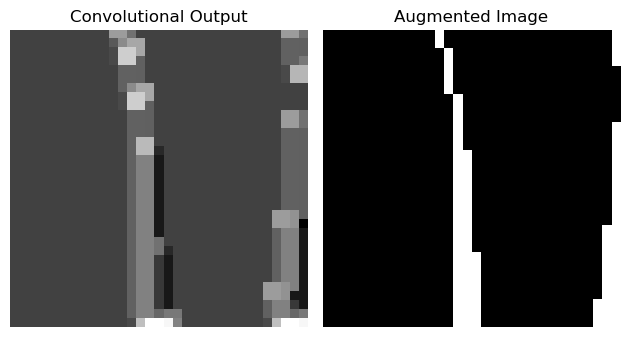

In [59]:
for i in range(3):
     augmentation_visualisation_with_conv(model)

## Trainen

In [60]:
# Training the model
model = Model()
model.cuda()
t = Trainer(model, 
            loss=nn.MSELoss(), 
            train_dl=train_dl, 
            valid_dl=valid_dl, 
            metrics=R2Score,
            halt_notebook=False) 


  0%|          | 0/40 [00:00<?, ?it/s]

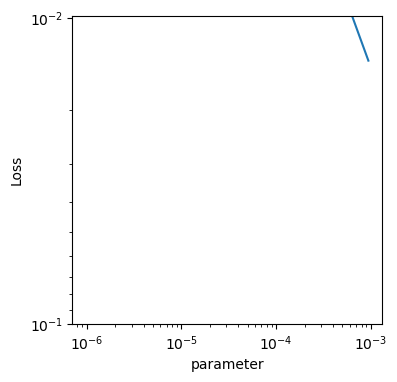

In [63]:
t.lr_find()

In [66]:
t.train(10, lr=(1e-4, 1e-2))

Total:   0%|          | 0/32960 [00:00<?, ?it/s]

Working on cuda:4
31 0.72s trainloss=0.09505 validloss=0.02773 R2Score=0.59664 
32 0.70s trainloss=0.01214 validloss=0.00734 R2Score=0.89328 
33 0.72s trainloss=0.00813 validloss=0.00952 R2Score=0.86147 
34 0.72s trainloss=0.00839 validloss=0.00892 R2Score=0.87017 
35 0.72s trainloss=0.00639 validloss=0.00928 R2Score=0.86504 
36 0.77s trainloss=0.00717 validloss=0.00755 R2Score=0.89015 
37 0.72s trainloss=0.00808 validloss=0.00760 R2Score=0.88945 
38 0.71s trainloss=0.00722 validloss=0.00763 R2Score=0.88898 
39 0.70s trainloss=0.00776 validloss=0.00749 R2Score=0.89100 
40 0.76s trainloss=0.00695 validloss=0.00708 R2Score=0.89705 
